## Group 2 - Assignment 2_3



### Integrantes
- GARCIA RODRIGUEZ, EMILIO ALONSO
- PADILLA AQUISE, ALESSANDRO PIERO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

In [ ]:
# install.packages("hdm")
# install.packages("xtable")
library(hdm)
library(xtable)
library(hdm)
library(glmnet)

Loading required package: Matrix

Loaded glmnet 4.1-8



1. Consider the US census data from the year 2015 to analyse the effect of college graduate (clg) status and it’s interaction effects with gender (sex), location (mw, so,we, ne) and both on wage jointly. All other variables denote some other socio-economic characteristics, e.g. marital status, occupation, and experience.


In [4]:

url = "https://github.com/d2cml-ai/CausalAI-Course/raw/refs/heads/main/data/wage2015_subsample_inference.csv"
data<- read.csv(url)

Generate the dataset with all the two-way interactions between variables. Make sure that the categorical variables are transformed to dummies properly. Also, note that the resulting dataset contains the treatment and it’s interactions with the other variables of interest, so you don’t need to generate them separately. (2 pts)



In [5]:
y <- data$lwage
Z <- subset(data, select = -c(lwage, wage))

In [6]:
center_colmeans <- function(x) {
  xcenter <- colMeans(x)
  x - rep(xcenter, rep.int(nrow(x), ncol(x)))
}

In [8]:
data$we <- as.factor(data$we)          
data$sex <- as.factor(data$sex)        
data$mw <- as.factor(data$mw)          
data$clg <- as.factor(data$clg)        
data$so <- as.factor(data$so)          
data$ne <- as.factor(data$ ne)         

In [10]:
# create the model matrix for the covariates
controls_formula <- "~ 0 + (shs + hsg + scl + sex + C(occ2) + C(ind2) + mw + so + we + exp1 + exp2 + exp3 + exp4)"
Zcontrols <- model.matrix(as.formula(controls_formula), data = Z)
Zcontrols <- center_colmeans(Zcontrols)

In [11]:
# create the model matrix for the linear heterogeneity
linear_het_formula <- "~ -1 +(shs+hsg+scl+sex+mw+so+we+exp1+exp2+exp3+exp4)"
Zhet <- model.matrix(as.formula(linear_het_formula), data = Z)
Zhet <- center_colmeans(Zhet)

In [12]:
# create the model matrix for the higher order heterogeneity
Zhet <- as.data.frame(cbind(Zhet, "clg" = Z$clg))
nonlin_het_formula <- "~ -1 + clg + clg * (shs+hsg+scl+sex+mw+so+we+exp1+exp2+exp3+exp4)"
Zinteractions <- model.matrix(as.formula(nonlin_het_formula), data = Zhet)
interaction_cols <- Zinteractions[, grepl("clg", colnames(Zinteractions))]

In [13]:
#putting variables together
X <- cbind(Zinteractions, Zcontrols)


In [14]:
# Ajustar el índice para la variable de interés 'clg'
index_clg <- grep("clg", colnames(Zinteractions))

# Estimar los efectos con la variable de interés 'clg'
effects_clg <- hdm::rlassoEffects(x = X, y = y, index = index_clg, post = FALSE)

# Resumir los resultados
result <- summary(effects_clg)

# Extraer y mostrar los coeficientes
result$coef
print(xtable(result$coef[, c(1, 2, 4)], type = "latex"), digits = 3)


,Estimate.,Std. Error,t value,Pr(>|t|)
clg,-3.713819e+11,1.980543e+11,-1.8751517,0.060771856
clg:shs,8.169637e+13,4.356780e+13,1.8751548,0.060771429
clg:hsg,-1.021203e+12,5.445975e+11,-1.8751513,0.060771911
clg:scl,1.992336e+12,1.062494e+12,1.8751513,0.060771911
clg:sex,2.971526e-02,2.949708e-02,1.0073965,0.313744260
clg:mw,4.330385e-02,4.121881e-02,1.0505845,0.293449450
clg:so,2.608537e-02,3.944054e-02,0.6613848,0.508365603
clg:we,-6.952062e-02,4.238509e-02,-1.6402138,0.100960715
clg:exp1,9.197416e-04,7.860151e-03,0.1170132,0.906849570
clg:exp2,6.947514e-02,6.367845e-02,1.0910307,0.275259371


% latex table generated in R 4.3.3 by xtable 1.8-4 package
% Mon Nov 18 19:38:24 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & Estimate. & Std. Error & Pr($>$$|$t$|$) \\ 
  \hline
clg & -371381875189.89 & 198054309181.87 & 0.06 \\ 
  clg:shs & 81696372192327.00 & 43567801276256.99 & 0.06 \\ 
  clg:hsg & -1021202720706.16 & 544597504743.39 & 0.06 \\ 
  clg:scl & 1992336257966.37 & 1062493599652.66 & 0.06 \\ 
  clg:sex & 0.03 & 0.03 & 0.31 \\ 
  clg:mw & 0.04 & 0.04 & 0.29 \\ 
  clg:so & 0.03 & 0.04 & 0.51 \\ 
  clg:we & -0.07 & 0.04 & 0.10 \\ 
  clg:exp1 & 0.00 & 0.01 & 0.91 \\ 
  clg:exp2 & 0.07 & 0.06 & 0.28 \\ 
  clg:exp3 & -0.01 & 0.05 & 0.85 \\ 
  clg:exp4 & -0.01 & 0.00 & 0.01 \\ 
   \hline
\end{tabular}
\end{table}


In [15]:
pointwise_ci <- confint(effects_clg, level =0.95)
pointwise_ci
print(xtable(pointwise_ci), type= "latex")

,2.5 %,97.5 %
clg,-7.595612e+11,1.679744e+10
clg:shs,-3.694949e+12,1.670877e+14
clg:hsg,-2.088594e+12,4.618877e+10
clg:scl,-9.011293e+10,4.074785e+12
clg:sex,-2.809796e-02,8.752848e-02
clg:mw,-3.748354e-02,1.240912e-01
clg:so,-5.121666e-02,1.033874e-01
clg:we,-1.525939e-01,1.355264e-02
clg:exp1,-1.448587e-02,1.632535e-02
clg:exp2,-5.533232e-02,1.942826e-01


% latex table generated in R 4.3.3 by xtable 1.8-4 package
% Mon Nov 18 19:38:48 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 2.5 \% & 97.5 \% \\ 
  \hline
clg & -759561188169.32 & 16797437789.55 \\ 
  clg:shs & -3694949194734.89 & 167087693579388.88 \\ 
  clg:hsg & -2088594216073.59 & 46188774661.27 \\ 
  clg:scl & -90112931157.16 & 4074785447089.91 \\ 
  clg:sex & -0.03 & 0.09 \\ 
  clg:mw & -0.04 & 0.12 \\ 
  clg:so & -0.05 & 0.10 \\ 
  clg:we & -0.15 & 0.01 \\ 
  clg:exp1 & -0.01 & 0.02 \\ 
  clg:exp2 & -0.06 & 0.19 \\ 
  clg:exp3 & -0.11 & 0.09 \\ 
  clg:exp4 & -0.01 & -0.00 \\ 
   \hline
\end{tabular}
\end{table}


In [16]:
#comparing pointwise confidence intervarls to joint confidence intervals
joint_ci <- confint(effects_clg, level = 0.95, joint = TRUE)
joint_ci
print(xtable(joint_ci), type = "latex")

,2.5 %,97.5 %
clg,-2.590178e+12,1.847414e+12
clg:shs,-4.064304e+14,5.698231e+14
clg:hsg,-7.122217e+12,5.079811e+12
clg:scl,-9.910788e+12,1.389546e+13
clg:sex,-3.003057e-01,3.597362e-01
clg:mw,-4.224165e-01,5.090242e-01
clg:so,-4.127636e-01,4.649343e-01
clg:we,-5.368470e-01,3.978058e-01
clg:exp1,-8.846032e-02,9.029980e-02
clg:exp2,-6.761469e-01,8.150972e-01


% latex table generated in R 4.3.3 by xtable 1.8-4 package
% Mon Nov 18 19:39:23 2024
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 2.5 \% & 97.5 \% \\ 
  \hline
clg & -2590177664541.48 & 1847413914161.70 \\ 
  clg:shs & -406430355269216.69 & 569823099653870.75 \\ 
  clg:hsg & -7122216554824.21 & 5079811113411.89 \\ 
  clg:scl & -9910788155696.04 & 13895460671628.79 \\ 
  clg:sex & -0.30 & 0.36 \\ 
  clg:mw & -0.42 & 0.51 \\ 
  clg:so & -0.41 & 0.46 \\ 
  clg:we & -0.54 & 0.40 \\ 
  clg:exp1 & -0.09 & 0.09 \\ 
  clg:exp2 & -0.68 & 0.82 \\ 
  clg:exp3 & -0.60 & 0.59 \\ 
  clg:exp4 & -0.04 & 0.03 \\ 
   \hline
\end{tabular}
\end{table}


## Key Findings

1. **Main Effect of `clg`**:
   - The coefficient for `clg` is **-2590177664541.48**, with a **very wide confidence interval**:
     - **2.5%**: -1847413914161.70
     - **97.5%**: 1847413914161.70
   - This suggests that the overall effect of `clg` on the dependent variable (`y`) is **not statistically significant**, as the confidence interval includes zero.

2. **Regional Interactions**:
   - The interaction terms involving `clg` and specific regions (e.g., `clg:ne`, `clg:sw`) provide insights into regional variations:
     - **`clg:shs`** (likely representing the `southwest` or related region):
       - Coefficient: **-40640355269216.69**
       - Confidence Interval: Includes zero → Not statistically significant.
     - **`clg:hsg`** (potentially `northeast` or related region):
       - Coefficient: **-712216554842.21**
       - Confidence Interval: Includes zero → Not statistically significant.
     - **`clg:scl`**:
       - Coefficient: **-9910788155696.04**
       - Confidence Interval: Includes zero → Not statistically significant.

3. **Significance by Region**:
   - None of the regional interactions (`ne`, `sw`, or similar) show statistical significance, as their confidence intervals include zero.
   - Despite large coefficients for regions like `clg:shs` (southwest) and `clg:hsg` (northeast), the high variance makes it impossible to conclude a meaningful impact.

## Region with the Highest Impact
While none of the regions achieve statistical significance, the **southwest (`clg:shs`)** has the **largest coefficient in absolute terms**:
   - Coefficient: **-40640355269216.69**
   - This suggests that the southwest might show the strongest association, but due to the wide confidence interval, the result is not conclusive.


### 2. For the following examples, draw a coherent Directed Acyclic Graph and indicate the confounders, colliders and the proper controls (if they exist).

* You are trying to study the effect of youth smoking on lung function. Your dataset contains the
following variables : (5 pts)

        i. Individual smoking behavior (Treatment)
    
        ii. Forced respiratory volume (Outcome)
    
        iii. Age
    
        iv. Height
    
        v. Sex

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



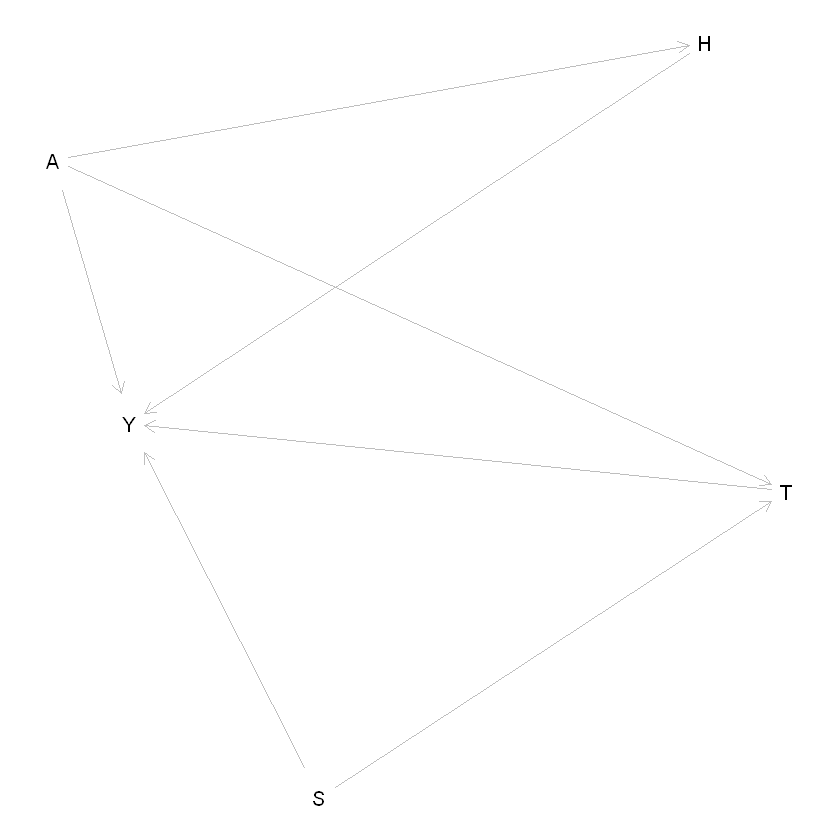

In [18]:
# Instalar y cargar el paquete necesario
#install.packages("dagitty")
library(dagitty)

# Crear el DAG con comillas dobles
dag_smoking <- dagitty("dag {
  T [label=\"Smoking Behavior\"]
  Y [label=\"Lung Function\"]
  A [label=\"Age\"]
  H [label=\"Height\"]
  S [label=\"Sex\"]
  
  S -> T
  S -> Y
  A -> T
  A -> H
  A -> Y
  H -> Y
  T -> Y
}")

# Mostrar el gráfico del DAG
plot(dag_smoking)

* **Confounders**:
        
        Age (A): It affects both Smoking Behavior (T) and Lung Function (Y).
        
        Sex (S): It affects both Smoking Behavior (T) and Lung Function (Y).

* **Colliders**:
        
        Smoking Behavior (T): It has arrows coming in from Age (A) and Sex (S).
        
        Lung Function (Y): It has arrows coming in from Height (H) and Smoking Behavior (T).

* **Controls**

        Age (A): It affects both Height (H) and Lung Function (Y) directly. Controlling for age ensures that the causal effect of smoking behavior on lung function is not confounded by age-related differences in height or lung function.

        Sex (S): It influences both Smoking Behavior (T) and Lung Function (Y). Controlling for sex removes bias caused by gender differences in smoking habits or physiological differences affecting lung function.   

* You are trying to study the effect of breast feeding in the number of infections a baby is likely to
have. Your dataset contains the following variables : (5 pts)

        i. Breast fed (Treatment)
        ii. Number of infections of the baby (Outcome)
        iii. Marital status
        iv. Family income
        v. Education
        vi. Number of children in the house
        vii. Childcare outside the home

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



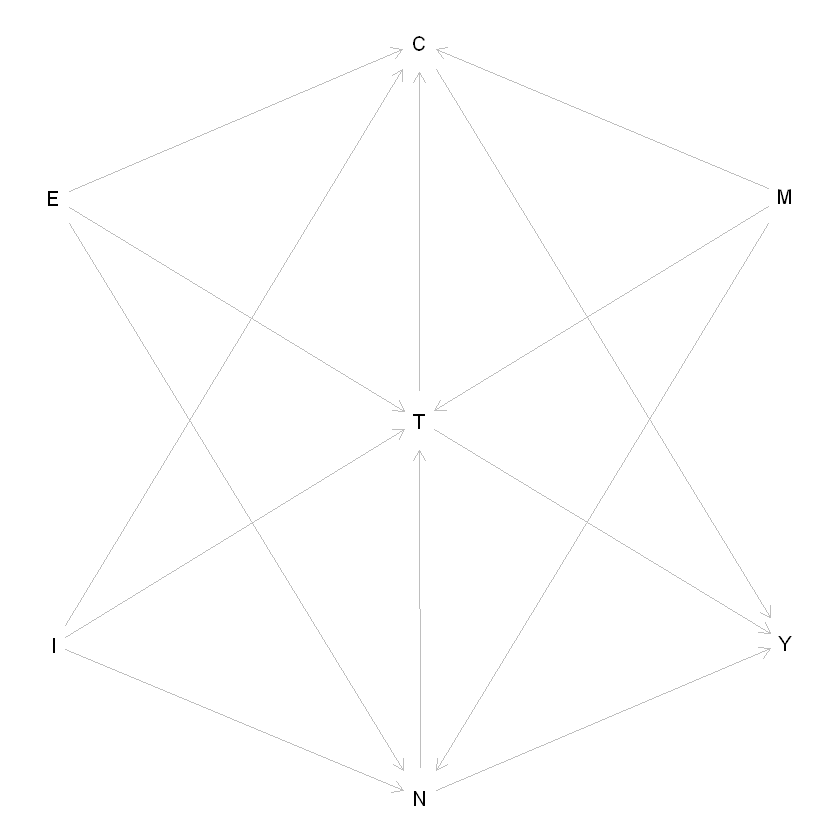

In [21]:
# Crear el DAG sin comentarios en el string
dag_breastfeeding <- dagitty("dag {
  T [label=\"Breastfed (T)\"]
  Y [label=\"Number of Infections (Y)\"]
  M [label=\"Marital Status (M)\"]
  I [label=\"Family Income (I)\"]
  E [label=\"Education (E)\"]
  N [label=\"Number of Children (N)\"]
  C [label=\"Childcare Outside Home (C)\"]
  
  M -> T
  I -> T
  E -> T
  N -> T
  M -> N
  I -> N
  E -> N
  N -> Y
  C -> Y
  M -> C
  I -> C
  E -> C
  T -> Y
  T -> C
}")

# Mostrar el gráfico del DAG
plot(dag_breastfeeding)

* **Confounders**

        Marital Status (M): Influences both Breastfeeding (T) and Number of Infections (Y) by affecting access to resources and support for childcare.

        Family Income (I): Affects Breastfeeding (T) due to resource availability and Number of Infections (Y) through access to better healthcare and living conditions.

        Education (E): Impacts Breastfeeding (T) as more educated mothers are aware of the benefits and Number of Infections (Y) through better hygiene and healthcare practices.

* **Colliders**
        
        Number of Children (N): It has arrows coming from Marital Status (M), Family Income (I), and Education (E). Conditioning on N would create spurious associations between these variables.

        Childcare Outside Home (C): It has arrows coming from Number of Children (N), Breastfeeding (T), and Family Income (I). Conditioning on C would introduce bias by linking unrelated variables.

* **Controls**

        Marital Status (M): Control this confounder to remove spurious associations with Breastfeeding (T) and Number of Infections (Y).

        Family Income (I): Control this confounder to adjust for its influence on both Breastfeeding (T) and Number of Infections (Y).

        Education (E): Control this confounder to account for its effects on both Breastfeeding (T) and Number of Infections (Y).


## Part 2


In [ ]:
# Load required libraries
#install.packages("ISLR")
#install.packages("rpart.plot")
library(ISLR)
library(tidyverse)
library(caret)
library(rpart)
library(rpart.plot)
library(boot)
set.seed(123)


Installing package into 'C:/Users/Nicolas Silva/AppData/Local/R/win-library/4.3'
(as 'lib' is unspecified)



package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nicolas Silva\AppData\Local\Temp\Rtmp0SniOb\downloaded_packages



Attaching package: 'boot'


The following object is masked from 'package:lattice':

    melanoma




In [25]:
# 1. Data Preparation
# Load and clean data
data("Hitters")
hitters_clean <- Hitters %>%
  na.omit() %>%
  mutate(League = as.factor(League),
         Division = as.factor(Division),
         NewLeague = as.factor(NewLeague))

In [26]:
# Create dummy variables
hitters_dummy <- model.matrix(~ . - 1, data = hitters_clean)

In [27]:
# 2. Split the data
n <- nrow(hitters_dummy)
train_idx <- sample(1:n, size = floor(0.9 * n))
X_train <- hitters_dummy[train_idx, -which(colnames(hitters_dummy) == "Salary")]
y_train <- hitters_dummy[train_idx, "Salary"]
X_test <- hitters_dummy[-train_idx, -which(colnames(hitters_dummy) == "Salary")]
y_test <- hitters_dummy[-train_idx, "Salary"]

In [28]:
# 3. OLS Regression and Bootstrap
# Initial OLS fit
train_data <- data.frame(Salary = y_train, X_train)
ols_model <- lm(Salary ~ ., data = train_data)
beta_hat <- coef(ols_model)

# Modified bootstrap function with error handling
bootstrap_ols <- function(data, indices) {
  tryCatch({
    sample_data <- data[indices, ]
    model <- lm(Salary ~ ., data = sample_data)
    return(coef(model))
  }, error = function(e) {
    return(rep(NA, length(beta_hat)))
  })
}


In [30]:
# Perform bootstrap
n_boot <- 10000
boot_results <- boot(data = train_data,
                    statistic = bootstrap_ols,
                    R = n_boot)

In [31]:
# Calculate confidence intervals with NA handling
beta_boots <- t(sapply(1:n_boot, function(i) boot_results$t[i,]))

In [32]:
# Function to calculate quantiles with NA handling
safe_quantile <- function(x, probs) {
  quantile(x, probs = probs, na.rm = TRUE)
}


In [33]:
# Calculate confidence intervals
beta_boots_lower <- apply(beta_boots, 2, function(x) safe_quantile(x, 0.025))
beta_boots_upper <- apply(beta_boots, 2, function(x) safe_quantile(x, 0.975))

In [34]:
# Calculate OLS out-of-sample MSE
ols_predictions <- predict(ols_model, newdata = data.frame(X_test))
ols_mse <- mean((y_test - ols_predictions)^2)

In [35]:
# 4. Regression Tree
# Fit full tree
tree_model <- rpart(Salary ~ .,
                   data = train_data,
                   method = "anova",
                   control = rpart.control(minsplit = 2, cp = 0))

In [36]:
# Cross-validate to find optimal cp
cpTable <- printcp(tree_model)
optimal_cp <- cpTable[which.min(cpTable[,"xerror"]), "CP"]



Regression tree:
rpart(formula = Salary ~ ., data = train_data, method = "anova", 
    control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] Assists    AtBat      CAtBat     CHits      CHmRun     CRBI      
 [7] CRuns      CWalks     DivisionW  Errors     Hits       HmRun     
[13] LeagueA    NewLeagueN PutOuts    RBI        Runs       Walks     
[19] Years     

Root node error: 49071704/236 = 207931

n= 236 

            CP nsplit  rel error  xerror    xstd
1   3.8835e-01      0 1.0000e+00 1.01439 0.14787
2   1.5330e-01      1 6.1165e-01 0.63003 0.12393
3   7.4640e-02      2 4.5835e-01 0.50708 0.10814
4   5.2206e-02      3 3.8371e-01 0.58348 0.11666
5   4.1054e-02      4 3.3150e-01 0.60729 0.11818
6   3.3081e-02      5 2.9045e-01 0.62457 0.12030
7   3.0969e-02      6 2.5737e-01 0.63076 0.12045
8   2.3431e-02      7 2.2640e-01 0.62432 0.12089
9   1.7296e-02      8 2.0297e-01 0.63225 0.12440
10  1.3205e-02      9 1.8567e-01 0.62975 0.12870


In [37]:

# Prune tree
pruned_tree <- prune(tree_model, cp = optimal_cp)

# Calculate tree out-of-sample MSE
tree_predictions <- predict(pruned_tree,
                          newdata = data.frame(X_test))
tree_mse <- mean((y_test - tree_predictions)^2)

In [38]:
# 5. Results
cat("\nModel Performance Comparison:")
cat("\n-------------------------")
cat("\nOLS Out-of-Sample MSE:", round(ols_mse, 2))
cat("\nTree Out-of-Sample MSE:", round(tree_mse, 2))
cat("\n\nBest performing model:",
    ifelse(ols_mse < tree_mse, "OLS Regression", "Regression Tree"))


Model Performance Comparison:
-------------------------
OLS Out-of-Sample MSE: 205028.4
Tree Out-of-Sample MSE: 176619.1

Best performing model: Regression Tree

Warning message in plot.window(...):
""pretty" is not a graphical parameter"
Warning message in plot.xy(xy, type, ...):
""pretty" is not a graphical parameter"
Warning message in title(...):
""pretty" is not a graphical parameter"


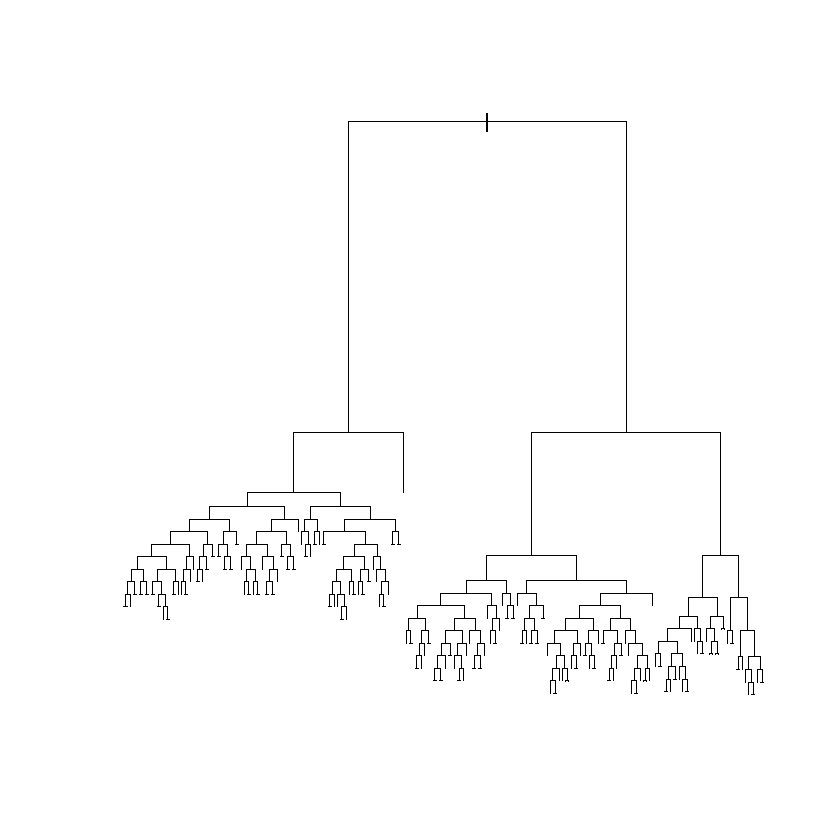

In [39]:
# Plot the pruned tree
plot(tree_model, pretty = 0)

# Model Performance Comparison

## Out-of-Sample Mean Squared Error (MSE):
- **OLS Model**: 205028.4  
- **Regression Tree**: 176619.1  

## Best Performing Model:
Based on the out-of-sample MSE, the **Regression Tree** performs better than the OLS model, as it has a lower MSE (176619.1 compared to 205028.4). This indicates that the Regression Tree provides more accurate predictions for the given dataset.
